Explanation of the Columns:
-   date: The date for the data entry (monthly).
-   PERMNO: A unique identifier for each stock in the dataset.
-   SHRCD: Share code to identify the type of stock (e.g., common stock = 10 or 11).
-   EXCHCD: Exchange code to identify where the stock is traded (NYSE = 1, AMEX = 2, NASDAQ = 3).
-   PRC: Stock price (negative if a bid/ask average is used).
-   RET: Holding period return for the stock.
-   SHROUT: Number of shares outstanding (in thousands).
-   Mkt-RF: Excess market return (Market Return - Risk-Free Rate).
-   RF: Risk-free rate.
-   R_IA: Investment factor , Invest Asset (the group’s allocated factor)

In [2]:
import numpy as np
from statsmodels.api import OLS, add_constant
import pandas as pd
from tqdm import tqdm

# Step 1: Load the dataset
data = pd.read_csv('crsp_final_data_last.csv', sep = ',')
data

,date,PERMNO,SHRCD,EXCHCD,PRC,RET,SHROUT,Mkt-RF,RMW,CMA,RF,R_IA
0,1986-09-30,10001.0,11.0,3.0,6.375000,-0.003077,991.0,-8.60,-0.08,3.71,0.45,3.2313
1,1986-10-31,10001.0,11.0,3.0,6.625000,0.039216,991.0,4.66,-0.05,1.00,0.46,0.5689
2,1986-11-28,10001.0,11.0,3.0,7.000000,0.056604,991.0,1.17,1.09,0.67,0.39,0.4243
3,1986-12-31,10001.0,11.0,3.0,7.000000,0.015000,991.0,-3.27,0.79,0.09,0.49,1.0661
4,1987-01-30,10001.0,11.0,3.0,6.750000,-0.035714,991.0,12.47,0.17,-1.00,0.42,-1.2538
...,...,...,...,...,...,...,...,...,...,...,...,...
2367929,2023-08-31,93436.0,11.0,3.0,258.079987,-0.034962,3173994.0,-2.39,3.42,-2.37,0.45,-0.8323
2367930,2023-09-29,93436.0,11.0,3.0,250.220001,-0.030456,3179000.0,-5.24,1.85,-0.84,0.43,-0.5022
2367931,2023-10-31,93436.0,11.0,3.0,200.839996,-0.197346,3178921.0,-3.18,2.47,-0.67,0.47,-0.3951
2367932,2023-11-30,93436.0,11.0,3.0,240.080002,0.195379,3178921.0,8.83,-3.81,-0.99,0.44,-2.2334


In [3]:
data['date'] = pd.to_datetime(data['date'])
print(data.dtypes)

date      datetime64[ns]
PERMNO           float64
SHRCD            float64
EXCHCD           float64
PRC              float64
RET              float64
SHROUT           float64
Mkt-RF           float64
RMW              float64
CMA              float64
RF               float64
R_IA             float64
dtype: object


In [4]:
# Step 2: check the Filter :  the data based on the project requirements
# Keep only stocks with price > $1, traded on NYSE, AMEX, or NASDAQ, and share codes 10 or 11
data_filtered = data[(data['PRC'] > 1) &
            (data['EXCHCD'].isin([1, 2, 3])) &
            (data['SHRCD'].isin([10, 11]))]
#data_filtered


#the number of rows doesn't change == filter well done

4) Using the nine factors defined above, each group will first calculate the exposure of each stock’s excess return to their allocated factor (by using a two-factor model,
- i.e. MKT + their allocated factor) using 60-month rolling window estimation period,
- i.e., the first estimation window should be 1/1973-12/1977, the second 2/1973-1/1978, and so on, and the last estimation window should be 1/2019-12/2023.

In [6]:
# Step 3: Sort the data by PERMNO (stock identifier) and date
data_sorted = data.sort_values(by=['PERMNO', 'date'])
#data_sorted


#data were already sorted correctly

In [7]:

# Calculate Excess_Return as RET - RF for each row
data['Excess_Return'] = data['RET'] - data['RF']

In [8]:
data

,date,PERMNO,SHRCD,EXCHCD,PRC,RET,SHROUT,Mkt-RF,RMW,CMA,RF,R_IA,Excess_Return
0,1986-09-30,10001.0,11.0,3.0,6.375000,-0.003077,991.0,-8.60,-0.08,3.71,0.45,3.2313,-0.453077
1,1986-10-31,10001.0,11.0,3.0,6.625000,0.039216,991.0,4.66,-0.05,1.00,0.46,0.5689,-0.420784
2,1986-11-28,10001.0,11.0,3.0,7.000000,0.056604,991.0,1.17,1.09,0.67,0.39,0.4243,-0.333396
3,1986-12-31,10001.0,11.0,3.0,7.000000,0.015000,991.0,-3.27,0.79,0.09,0.49,1.0661,-0.475000
4,1987-01-30,10001.0,11.0,3.0,6.750000,-0.035714,991.0,12.47,0.17,-1.00,0.42,-1.2538,-0.455714
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2367929,2023-08-31,93436.0,11.0,3.0,258.079987,-0.034962,3173994.0,-2.39,3.42,-2.37,0.45,-0.8323,-0.484962
2367930,2023-09-29,93436.0,11.0,3.0,250.220001,-0.030456,3179000.0,-5.24,1.85,-0.84,0.43,-0.5022,-0.460456
2367931,2023-10-31,93436.0,11.0,3.0,200.839996,-0.197346,3178921.0,-3.18,2.47,-0.67,0.47,-0.3951,-0.667346
2367932,2023-11-30,93436.0,11.0,3.0,240.080002,0.195379,3178921.0,8.83,-3.81,-0.99,0.44,-2.2334,-0.244621


In [9]:

"""
    Calculate rolling betas for each stock using a two-factor model:
    Excess Return (RET - RF) = beta1 * (Mkt-RF) + beta2 * (R_IA) + epsilon
"""


def calculate_rolling_betas_without_significance(group, window_size=60, min_valid=30):
    results = []
    num_rows = len(group)

    # Skip groups smaller than window_size
    if num_rows < window_size:
        return results

    # Convert columns to NumPy arrays for faster computations
    excess_return = group['Excess_Return'].to_numpy()
    mkt_rf = group['Mkt-RF'].to_numpy()
    r_ia = group['R_IA'].to_numpy()
    dates = group['date'].to_numpy()

    # Precompute rolling windows indices
    for start in range(num_rows - window_size + 1):
        end = start + window_size
        window_excess_return = excess_return[start:end]
        window_mkt_rf = mkt_rf[start:end]
        window_r_ia = r_ia[start:end]

        # Check for at least `min_valid` non-missing values
        valid_indices = (
            ~np.isnan(window_excess_return) &
            ~np.isnan(window_mkt_rf) &
            ~np.isnan(window_r_ia)
        )
        if np.sum(valid_indices) >= min_valid:
            # Keep only valid rows
            X = np.column_stack((window_mkt_rf[valid_indices], window_r_ia[valid_indices]))
            Y = window_excess_return[valid_indices]

            # Add constant for regression
            X = add_constant(X)

            # Perform regression
            model = OLS(Y, X).fit()

            # Calculate mean absolute error for epsilon
            epsilon_mean = np.mean(Y - model.predict(X))

            results.append({
                'PERMNO': group['PERMNO'].iloc[0],
                'End_Date': dates[end - 1],
                'Beta_Mkt_RF': model.params[1],
                'Beta_IA': model.params[2],
                'Epsilon': epsilon_mean,
                'P_Value_Mkt_RF': model.pvalues[1],
                'P_Value_IA': model.pvalues[2],
                'R_Squared': model.rsquared
            })
    return results

def calculate_rolling_betas_with_significance(group, window_size=60, min_valid=30):
    results = []
    num_rows = len(group)

    # Skip groups smaller than window_size
    if num_rows < window_size:
        return results

    # Convert columns to NumPy arrays for faster computations
    excess_return = group['Excess_Return'].to_numpy()
    mkt_rf = group['Mkt-RF'].to_numpy()
    r_ia = group['R_IA'].to_numpy()
    dates = group['date'].to_numpy()

    # Precompute rolling windows indices
    for start in range(num_rows - window_size + 1):
        end = start + window_size
        window_excess_return = excess_return[start:end]
        window_mkt_rf = mkt_rf[start:end]
        window_r_ia = r_ia[start:end]

        # Check for at least `min_valid` non-missing values
        valid_indices = (
            ~np.isnan(window_excess_return) &
            ~np.isnan(window_mkt_rf) &
            ~np.isnan(window_r_ia)
        )
        if np.sum(valid_indices) >= min_valid:
            # Keep only valid rows
            X = np.column_stack((window_mkt_rf[valid_indices], window_r_ia[valid_indices]))
            Y = window_excess_return[valid_indices]

            # Add constant for regression
            X = add_constant(X)

            # Perform regression
            model = OLS(Y, X).fit()

            # Replace coefficients with 0 if not significant
            beta_mkt_rf = model.params[1] if model.pvalues[1] < 0.05 else 0
            beta_ia = model.params[2] if model.pvalues[2] < 0.05 else 0
            epsilon_mean = np.mean(Y - model.predict(X)) if model.rsquared > 0.05 else 0

            results.append({
                'PERMNO': group['PERMNO'].iloc[0],
                'End_Date': dates[end - 1],
                'Beta_Mkt_RF': beta_mkt_rf,
                'Beta_IA': beta_ia,
                'Epsilon': epsilon_mean,
                'P_Value_Mkt_RF': model.pvalues[1],
                'P_Value_IA': model.pvalues[2],
                'R_Squared': model.rsquared
            })
    return results

# Optimized processing for large datasets
def process_large_dataset(data, window_size=60, min_valid=30, significance_check=False):
    all_results = []
    groups = data.groupby('PERMNO')

    # Use tqdm for progress tracking
    for _, group in tqdm(groups, desc="Processing groups"):
        if significance_check:
            group_results = calculate_rolling_betas_with_significance(group, window_size, min_valid)
        else:
            group_results = calculate_rolling_betas_without_significance(group, window_size, min_valid)
        all_results.extend(group_results)

    return pd.DataFrame(all_results)



results_df = process_large_dataset(data, window_size=60, min_valid=30, significance_check= False)
results_df.to_csv("All_rolling_betas.csv", index=False)


Processing groups: 100%|██████████| 20927/20927 [23:53<00:00, 14.60it/s] 


In [10]:
results_df

,PERMNO,End_Date,Beta_Mkt_RF,Beta_IA,Epsilon,P_Value_Mkt_RF,P_Value_IA,R_Squared
0,10001.0,1993-03-31,0.001805,0.000104,-8.234154e-17,0.702096,0.994508,0.004077
1,10001.0,1993-06-30,0.002471,0.003491,8.789266e-17,0.615288,0.822722,0.004616
2,10001.0,1993-08-31,0.002654,0.003278,2.146431e-16,0.595069,0.835446,0.005328
3,10001.0,1993-09-30,0.002282,0.002296,2.294461e-16,0.653214,0.886264,0.004005
4,10001.0,1993-10-29,0.001875,0.000005,0.000000e+00,0.718668,0.999773,0.003559
...,...,...,...,...,...,...,...,...
1410775,93436.0,2023-08-31,0.021781,-0.008041,6.476301e-18,0.000408,0.395983,0.232759
1410776,93436.0,2023-09-29,0.022685,-0.007119,6.661338e-17,0.000230,0.454035,0.243428
1410777,93436.0,2023-10-31,0.025389,-0.007950,2.498002e-17,0.000067,0.412321,0.273904
1410778,93436.0,2023-11-30,0.023925,-0.007310,-3.700743e-18,0.000164,0.458797,0.249919


In [11]:
results_df_with_significance = process_large_dataset(data, window_size=60, min_valid=30, significance_check= True)
results_df_with_significance.to_csv("significant_rolling_betas.csv", index=False)
results_df_with_significance

Processing groups: 100%|██████████| 20927/20927 [16:30<00:00, 21.12it/s]


,PERMNO,End_Date,Beta_Mkt_RF,Beta_IA,Epsilon,P_Value_Mkt_RF,P_Value_IA,R_Squared
0,10001.0,1993-03-31,0.000000,0.0,0.000000e+00,0.702096,0.994508,0.004077
1,10001.0,1993-06-30,0.000000,0.0,0.000000e+00,0.615288,0.822722,0.004616
2,10001.0,1993-08-31,0.000000,0.0,0.000000e+00,0.595069,0.835446,0.005328
3,10001.0,1993-09-30,0.000000,0.0,0.000000e+00,0.653214,0.886264,0.004005
4,10001.0,1993-10-29,0.000000,0.0,0.000000e+00,0.718668,0.999773,0.003559
...,...,...,...,...,...,...,...,...
1410775,93436.0,2023-08-31,0.021781,0.0,6.476301e-18,0.000408,0.395983,0.232759
1410776,93436.0,2023-09-29,0.022685,0.0,6.661338e-17,0.000230,0.454035,0.243428
1410777,93436.0,2023-10-31,0.025389,0.0,2.498002e-17,0.000067,0.412321,0.273904
1410778,93436.0,2023-11-30,0.023925,0.0,-3.700743e-18,0.000164,0.458797,0.249919


In [12]:
# Mean
mean_beta_mkt_rf = results_df_with_significance['Beta_Mkt_RF'].mean()
mean_beta_ia = results_df_with_significance['Beta_IA'].mean()
mean_R_Squared = results_df_with_significance['R_Squared'].mean()


print(f"Mean Beta_Mkt_RF: {mean_beta_mkt_rf:.4f}")
print(f"Mean Beta_IA: {mean_beta_ia:.4f}")
print(f"Mean_R_Squared : {mean_R_Squared:.4f}")


Mean Beta_Mkt_RF: 0.0105
Mean Beta_IA: 0.0004
Mean_R_Squared : 0.1528


In [13]:
# Calculer les écarts types des betas
std_beta_mkt_rf = results_df_with_significance['Beta_Mkt_RF'].std()
std_beta_ia = results_df_with_significance['Beta_IA'].std()

# Afficher les résultats
print(f"Standard Deviation of Beta_Mkt_RF: {std_beta_mkt_rf:.4f}")
print(f"Standard Deviation of Beta_IA: {std_beta_ia:.4f}")


Standard Deviation of Beta_Mkt_RF: 0.0106
Standard Deviation of Beta_IA: 0.0113


Code pour les graphes de la Partie interpretation

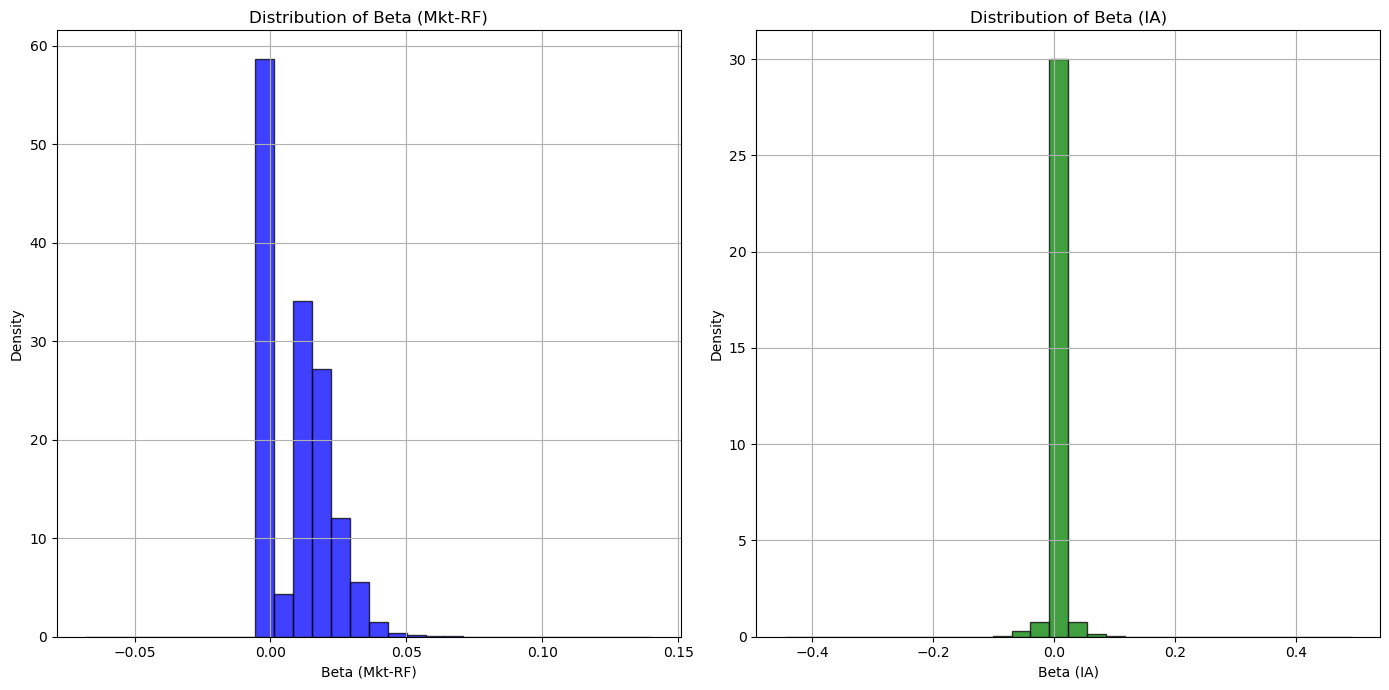

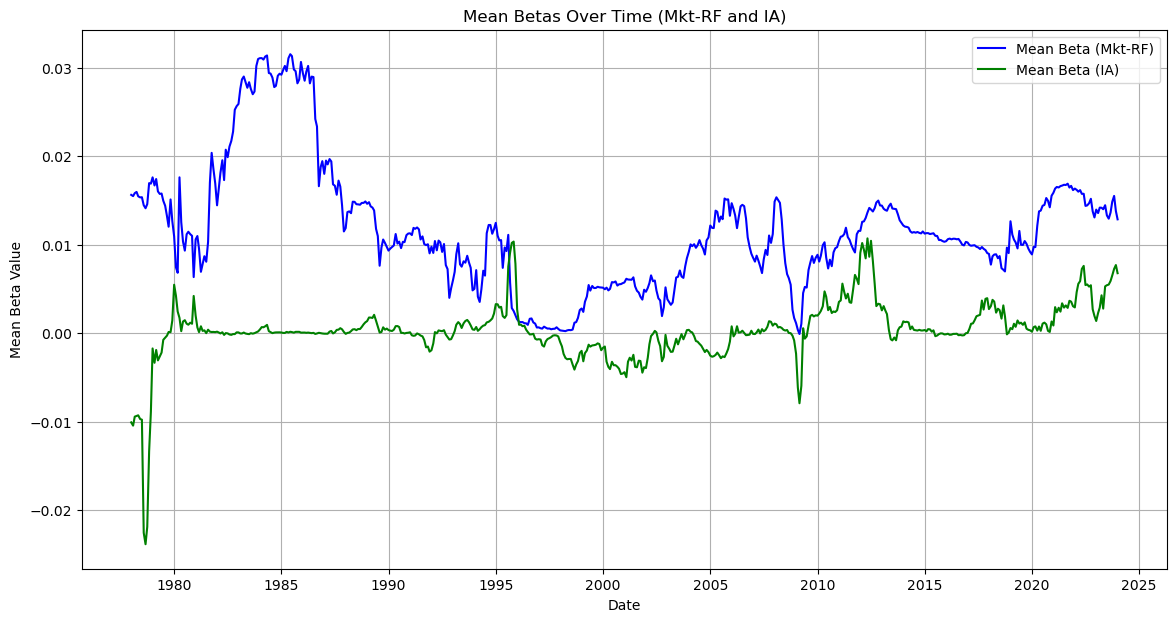

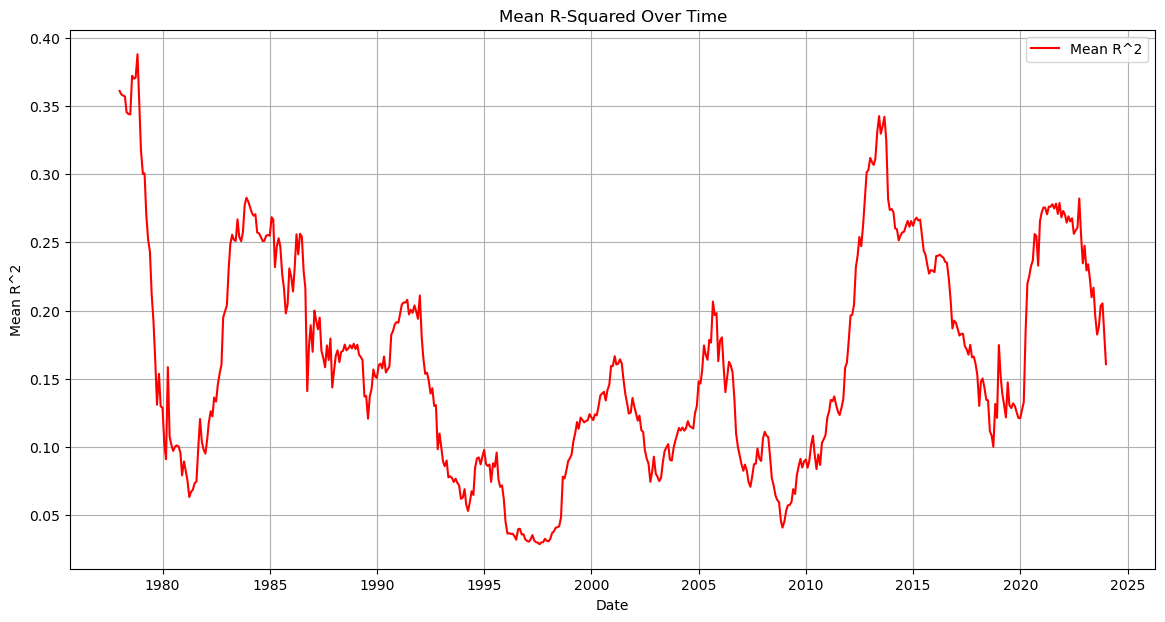

In [15]:
import matplotlib.pyplot as plt

# Ensure data is filtered for meaningful observations
filtered_results_df = results_df_with_significance.dropna(subset=["Beta_Mkt_RF", "Beta_IA"])
filtered_results_df = filtered_results_df[
    (filtered_results_df["Beta_Mkt_RF"] >= -0.5) & (filtered_results_df["Beta_Mkt_RF"] <= 0.5) &
    (filtered_results_df["Beta_IA"] >= -0.5) & (filtered_results_df["Beta_IA"] <= 0.5)
]


# 2. Distribution of Betas
plt.figure(figsize=(14, 7))

# Plot Beta (Mkt-RF)
plt.subplot(1, 2, 1)
plt.hist(filtered_results_df["Beta_Mkt_RF"], bins=30, alpha=0.75, color='blue', edgecolor='black', density=True)
plt.title("Distribution of Beta (Mkt-RF)")
plt.xlabel("Beta (Mkt-RF)")
plt.ylabel("Density")
plt.grid(True)

# Plot Beta (IA)
plt.subplot(1, 2, 2)
plt.hist(filtered_results_df["Beta_IA"], bins=30, alpha=0.75, color='green', edgecolor='black', density=True)
plt.title("Distribution of Beta (IA)")
plt.xlabel("Beta (IA)")
plt.ylabel("Density")
plt.grid(True)

plt.tight_layout()
plt.show()

# 3. Mean Betas Over Time (All Stocks)
mean_betas = filtered_results_df.groupby("End_Date")[["Beta_Mkt_RF", "Beta_IA"]].mean()

plt.figure(figsize=(14, 7))
plt.plot(mean_betas.index, mean_betas["Beta_Mkt_RF"], label="Mean Beta (Mkt-RF)", color='blue')
plt.plot(mean_betas.index, mean_betas["Beta_IA"], label="Mean Beta (IA)", color='green')

plt.title("Mean Betas Over Time (Mkt-RF and IA)")
plt.xlabel("Date")
plt.ylabel("Mean Beta Value")
plt.legend()
plt.grid(True)
plt.show()

# 4. R-Squared Trends Over Time
mean_r_squared = filtered_results_df.groupby("End_Date")["R_Squared"].mean()

plt.figure(figsize=(14, 7))
plt.plot(mean_r_squared.index, mean_r_squared, label="Mean R^2", color='red')

plt.title("Mean R-Squared Over Time")
plt.xlabel("Date")
plt.ylabel("Mean R^2")
plt.legend()
plt.grid(True)
plt.show()


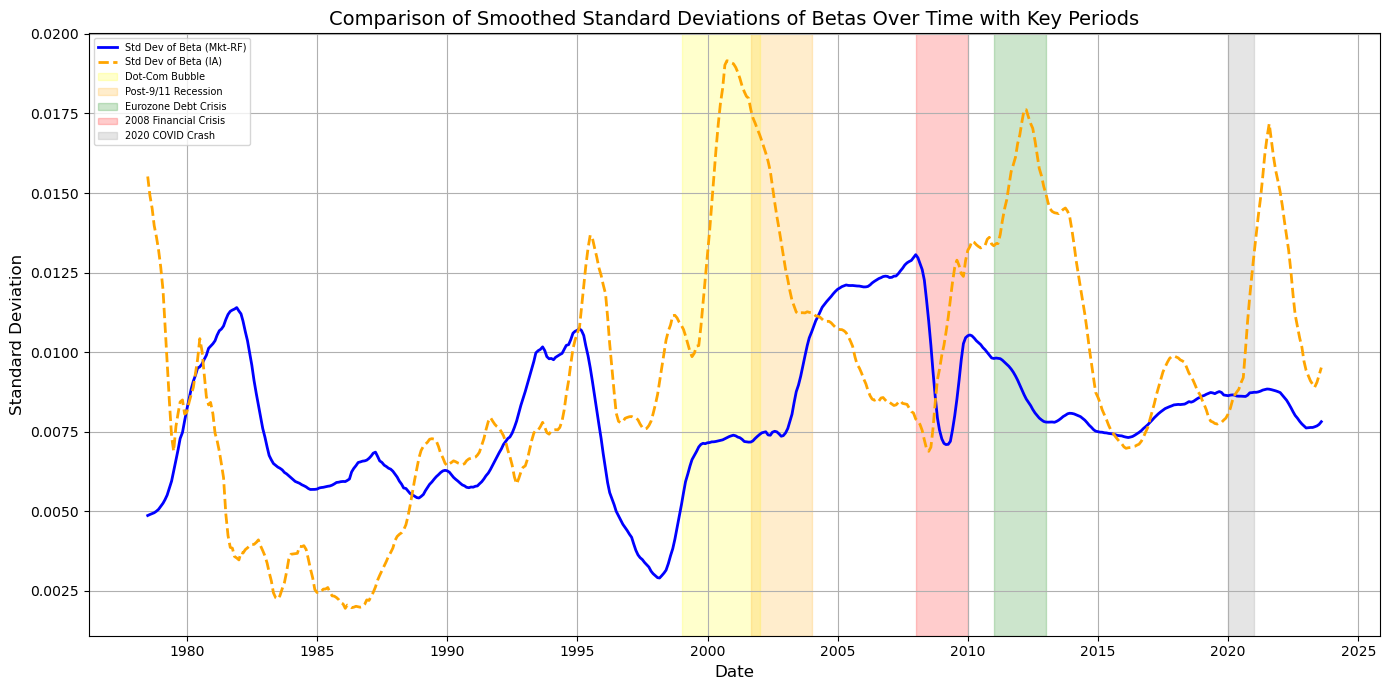

In [16]:
# Define significant periods with corresponding color codes
highlight_periods = {
    "Dot-Com Bubble": ("1999-01-01", "2001-12-31", "yellow"),
    "Post-9/11 Recession": ("2001-09-01", "2003-12-31", "orange"),
    "Eurozone Debt Crisis": ("2011-01-01", "2012-12-31", "green"),
    "2008 Financial Crisis": ("2008-01-01", "2009-12-31", "red"),
    "2020 COVID Crash": ("2020-01-01", "2020-12-31", "grey")
}
# Calculate and smooth standard deviations
std_betas = results_df_with_significance.groupby("End_Date")[["Beta_Mkt_RF", "Beta_IA"]].std()
std_betas_smooth = std_betas.rolling(window=12, center=True).mean()  # Example: 12-month rolling average


# Plot Standard Deviations with Highlighted Periods
plt.figure(figsize=(14, 7))

# Smoothed standard deviations for better presentation
plt.plot(std_betas_smooth.index, std_betas_smooth["Beta_Mkt_RF"], label="Std Dev of Beta (Mkt-RF)", color="blue", linewidth=2)
plt.plot(std_betas_smooth.index, std_betas_smooth["Beta_IA"], label="Std Dev of Beta (IA)", color="orange", linestyle="--", linewidth=2)

# Highlight key periods with specific colors
for label, (start, end, color) in highlight_periods.items():
    plt.axvspan(start, end, alpha=0.2, color=color, label=label)

# Title and labels
plt.title("Comparison of Smoothed Standard Deviations of Betas Over Time with Key Periods", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Standard Deviation", fontsize=12)
plt.legend(loc="upper left", fontsize=7)
plt.grid(True)

plt.tight_layout()
plt.show()


5) Using the betas estimated in step 4, each group will then create a monthly trading strategy and form 10 portfolios (both equally- and value-weighted) each month starting in 12/1977 and ending in 11/2023.

In [18]:
#Upload le fichier factors_data qui contient les facteurs de Fama & French (F-F_Research_Data_Factors_pre.csv sur TEAMS)
factors_data = pd.read_csv('F-F_Research_Data_Factors_pre.csv', sep = ',')
factors_data

,year,month,Mkt-RF,SMB,HML,RMW,CMA,RF
0,1963,7,-0.39,-0.41,-0.97,0.68,-1.18,0.27
1,1963,8,5.07,-0.80,1.80,0.36,-0.35,0.25
2,1963,9,-1.57,-0.52,0.13,-0.71,0.29,0.27
3,1963,10,2.53,-1.39,-0.10,2.80,-2.01,0.29
4,1963,11,-0.85,-0.88,1.75,-0.51,2.24,0.27
...,...,...,...,...,...,...,...,...
732,2024,7,1.24,8.28,5.74,0.22,0.43,0.45
733,2024,8,1.61,-3.65,-1.13,0.85,0.86,0.48
734,2024,9,1.74,-1.02,-2.59,0.04,-0.26,0.40
735,2024,10,-0.97,-0.88,0.89,-1.38,1.03,0.39


Number of NaN values in RET: 345
Statistiques Beta_IA après filtrage : count    133752.000000
mean          0.003882
std           0.036523
min          -0.445063
25%          -0.028029
50%           0.014118
75%           0.027492
max           0.516253
Name: Beta_IA, dtype: float64
   Portfolio   Beta_IA
0        1.0 -0.039267
1        2.0 -0.017660
2        3.0 -0.010415
3        4.0 -0.003999
4        5.0  0.002183
5        6.0  0.008946
6        7.0  0.014654
7        8.0  0.019160
8        9.0  0.024792
9       10.0  0.040778


C:\Users\isabe\AppData\Local\Temp\ipykernel_8288\2634397834.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_beta = LS_merged_data.groupby("End_Date", group_keys=False).apply(assign_portfolios).reset_index(drop=True)


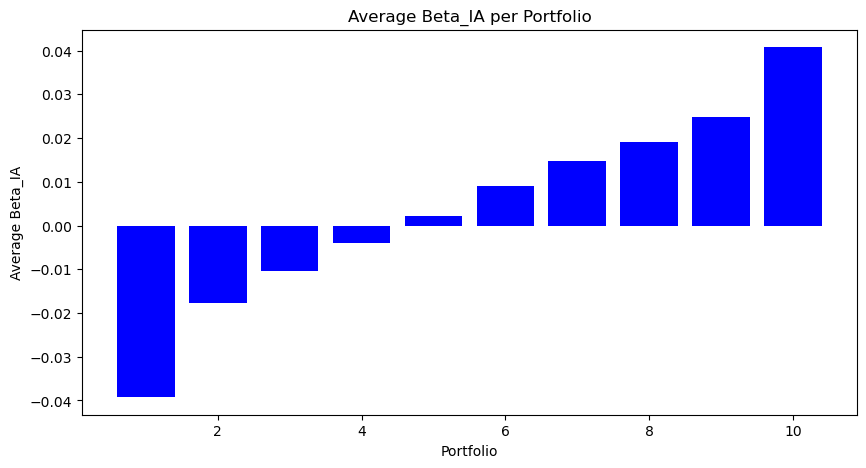

Valeurs uniques de Beta_IA après classement : [-0.07715949 -0.04937941 -0.04789357 ...  0.075298    0.07928598
  0.09520446]


C:\Users\isabe\AppData\Local\Temp\ipykernel_8288\2634397834.py:86: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  portfolio_returns = df_beta.groupby(["End_Date", "Portfolio"]).apply(compute_portfolio_returns).reset_index()


In [19]:
# Convertir 'year' et 'month' en une seule colonne de type datetime correspondant à la fin du mois
factors_data["Date"] = pd.to_datetime(factors_data["year"].astype(str) + "-" + factors_data["month"].astype(str)) + pd.offsets.MonthEnd(0)

# Convertir 'End_Date' dans results_df_with_significance pour qu'il corresponde aussi à la fin du mois
results_df_with_significance["End_Date"] = pd.to_datetime(results_df_with_significance["End_Date"]) + pd.offsets.MonthEnd(0)


#récupérer le nombre de share outsatnding dans data
data["date"] = pd.to_datetime(data["date"]) + pd.offsets.MonthEnd(0)  # Assurer que la date est bien la fin du mois

# Fusionner les données avec les facteurs Fama-French
LS_merged_data = results_df_with_significance.merge(factors_data, left_on="End_Date", right_on="Date", how="left")


LS_merged_data = LS_merged_data.merge(data[["date", "PERMNO", "SHROUT", "PRC"]],
                                      left_on=["End_Date", "PERMNO"],
                                      right_on=["date", "PERMNO"],
                                      how="left")


# Supprimer les colonnes inutiles
LS_merged_data.drop(columns=["year", "month", "Date"], inplace=True)

# Supprimer les lignes où `Beta_IA == 0` avant de classer**
LS_merged_data = LS_merged_data[LS_merged_data["Beta_IA"] != 0]

# Ajouter la capitalisation boursière
LS_merged_data = LS_merged_data.copy()

#making sure they are numerical values
LS_merged_data["PRC"] = pd.to_numeric(LS_merged_data["PRC"], errors='coerce')
LS_merged_data["SHROUT"] = pd.to_numeric(LS_merged_data["SHROUT"], errors='coerce')

LS_merged_data["Market_Cap"] = LS_merged_data["PRC"] * LS_merged_data["SHROUT"]
#compute return of each stock
LS_merged_data["RET"] = LS_merged_data.groupby("PERMNO")["PRC"].pct_change()

#Deal with Nan values
LS_merged_data["RET"] = LS_merged_data.groupby("End_Date")["RET"].transform(lambda x: x.fillna(x.mean()))

#drop nan values
#LS_merged_data = LS_merged_data.dropna(subset=["RET"])

#check nan
print("Number of NaN values in RET:", LS_merged_data["RET"].isna().sum())

# Vérifier la distribution de Beta_IA après filtrage**
print("Statistiques Beta_IA après filtrage :", LS_merged_data["Beta_IA"].describe())

# Appliquer le classement et créer les portefeuilles**
def assign_portfolios(group):
    group = group.sort_values("Beta_IA", ascending=True)  # Ensure sorting before ranking
    group["Portfolio"] = pd.qcut(group["Beta_IA"], 10, labels=False,duplicates='drop') + 1  # Ensures balanced deciles
    return group

df_beta = LS_merged_data.groupby("End_Date", group_keys=False).apply(assign_portfolios).reset_index(drop=True)

#check the sorting of the beta IA
beta_ia_check = df_beta.groupby("Portfolio")["Beta_IA"].mean().reset_index()
print(beta_ia_check)

#check beta IA for each portfolio
plt.figure(figsize=(10,5))
plt.bar(beta_ia_check["Portfolio"], beta_ia_check["Beta_IA"], color="blue")
plt.xlabel("Portfolio")
plt.ylabel("Average Beta_IA")
plt.title("Average Beta_IA per Portfolio")
plt.show()

# Vérifier qu'il ne reste plus de Beta_IA == 0**
print("Valeurs uniques de Beta_IA après classement :", df_beta["Beta_IA"].unique())

# Compute Portfolio Returns (Equally & Value-Weighted)
def compute_portfolio_returns(group):
    equally_weighted_return = group["RET"].mean()  # Simple average

    total_market_cap = group["Market_Cap"].sum()
    value_weighted_return = (group["RET"] * group["Market_Cap"]).sum() / total_market_cap if total_market_cap > 0 else None

    return pd.Series({
        "Equally_Weighted_Return": equally_weighted_return,
        "Value_Weighted_Return": value_weighted_return
    })

# Compute monthly returns per portfolio
portfolio_returns = df_beta.groupby(["End_Date", "Portfolio"]).apply(compute_portfolio_returns).reset_index()

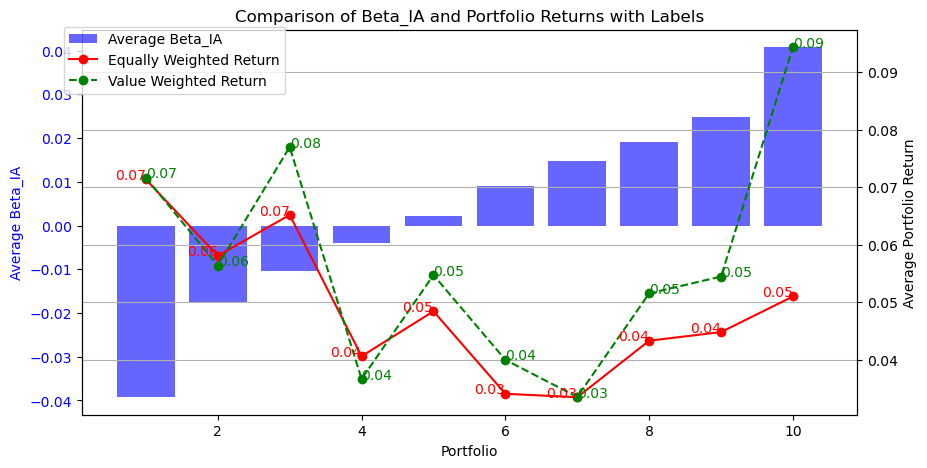

In [20]:
#Portfolios plots of these returns

# Compute average returns per portfolio
avg_returns = portfolio_returns.groupby("Portfolio")[["Equally_Weighted_Return", "Value_Weighted_Return"]].mean().reset_index()

# Create figure with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Bar plot for Beta_IA
ax1.bar(beta_ia_check["Portfolio"], beta_ia_check["Beta_IA"], color="blue", alpha=0.6, label="Average Beta_IA")
ax1.set_xlabel("Portfolio")
ax1.set_ylabel("Average Beta_IA", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

# Line plot for Portfolio Returns (Equally & Value-Weighted)
ax2 = ax1.twinx()
ax2.plot(avg_returns["Portfolio"], avg_returns["Equally_Weighted_Return"], color="red", marker="o", label="Equally Weighted Return")
ax2.plot(avg_returns["Portfolio"], avg_returns["Value_Weighted_Return"], color="green", marker="o", linestyle="--", label="Value Weighted Return")
ax2.set_ylabel("Average Portfolio Return", color="black")
ax2.tick_params(axis='y', labelcolor="black")

# Add labels directly on data points for better readability
for i in range(len(avg_returns)):
    ax2.text(avg_returns["Portfolio"][i], avg_returns["Equally_Weighted_Return"][i],
             f'{avg_returns["Equally_Weighted_Return"][i]:.2f}',
             fontsize=10, color="red", ha='right')

    ax2.text(avg_returns["Portfolio"][i], avg_returns["Value_Weighted_Return"][i],
             f'{avg_returns["Value_Weighted_Return"][i]:.2f}',
             fontsize=10, color="green", ha='left')

# Title and legend
plt.title("Comparison of Beta_IA and Portfolio Returns with Labels")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.grid(True)
plt.show()


#Question 6:  Finally, next-month average raw return, CAPM alpha, Fama-French 3-factor alpha, and Fama-French 5-factor alpha of the 10 portfolios as well as the arbitrage portfolio that is
#long in portfolio 10 and short in portfolio 1 will be reported. The significance (t-statistics)
#of the return and alphas of the long-short arbitrage portfolio should also be reported. (Any graphs or supplementary tables can also be reported).

In [22]:
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [23]:
# -------------------------------
# Merge Portfolio Returns with Factor Data
# -------------------------------

# Merge portfolio returns with factor data
portfolio_data = portfolio_returns.merge(factors_data, left_on="End_Date", right_on="Date", how="left")

# Compute excess returns for both weighting schemes
portfolio_data['Excess_Equally_Weighted'] = portfolio_data['Equally_Weighted_Return'] - portfolio_data['RF']
portfolio_data['Excess_Value_Weighted'] = portfolio_data['Value_Weighted_Return'] - portfolio_data['RF']

# -------------------------------
# Define a Function to Run Regressions
# -------------------------------
def run_regression(y, X):
    """Run an OLS regression and return the results."""
    X = sm.add_constant(X)  # Add constant term for alpha
    model = sm.OLS(y, X, missing='drop')
    results = model.fit()
    return results

# Define factor sets for different models
factor_sets = {
    'CAPM': ['Mkt-RF'],
    'FF3': ['Mkt-RF', 'SMB', 'HML'],
    'FF5': ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
}

# -------------------------------
# Compute Regression Results for Each Portfolio (1-10)
# -------------------------------
results_list = []  # Store regression results

for portfolio in sorted(portfolio_data['Portfolio'].unique()):
    # Filter data for this portfolio
    data_portfolio = portfolio_data[portfolio_data['Portfolio'] == portfolio].copy()

    # Compute average returns
    avg_equal_return = data_portfolio['Equally_Weighted_Return'].mean()
    avg_value_return = data_portfolio['Value_Weighted_Return'].mean()

    # Dictionary to store regression results
    reg_results = {"Portfolio": portfolio, "Avg_Equal_Weighted_Return": avg_equal_return, "Avg_Value_Weighted_Return": avg_value_return}

    # Run regressions for both equally weighted and value-weighted returns
    for weight_type, excess_col in [('Equal_Weighted', 'Excess_Equally_Weighted'), ('Value_Weighted', 'Excess_Value_Weighted')]:
        for model_name, factors in factor_sets.items():
            X = data_portfolio[factors]
            y = data_portfolio[excess_col]
            res = run_regression(y, X)
            reg_results[f"{model_name}_alpha_{weight_type}"] = res.params['const']
            reg_results[f"{model_name}_tstat_{weight_type}"] = res.tvalues['const']

    # Append to results list
    results_list.append(reg_results)

# Convert results to DataFrame
portfolio_results = pd.DataFrame(results_list)
print("Portfolio Regression Results:")
print(portfolio_results)

# -------------------------------
# Compute Arbitrage Portfolio (Long P10 - Short P1)
# -------------------------------
portfolio_data["Portfolio"] = portfolio_data["Portfolio"].astype(int)

# Pivot the returns so that each portfolio is a column
pivot_returns = portfolio_data.pivot(index="End_Date", columns="Portfolio", values=["Equally_Weighted_Return", "Value_Weighted_Return"])

# Flatten MultiIndex column names
pivot_returns.columns = ['_'.join(map(str, col)) if isinstance(col, tuple) else col for col in pivot_returns.columns]

# Compute arbitrage return (P10 - P1) for both weighting schemes
pivot_returns["Arbitrage_Equally_Weighted"] = (pivot_returns["Equally_Weighted_Return_10"].fillna(0) -
                                               pivot_returns["Equally_Weighted_Return_1"].fillna(0))

pivot_returns["Arbitrage_Value_Weighted"] = (pivot_returns["Value_Weighted_Return_10"].fillna(0) -
                                             pivot_returns["Value_Weighted_Return_1"].fillna(0))

# Merge arbitrage returns with factor data
arb_data = pivot_returns[['Arbitrage_Equally_Weighted', 'Arbitrage_Value_Weighted']].reset_index().merge(factors_data, left_on="End_Date", right_on="Date", how="left")

# Compute excess arbitrage return
arb_data['Excess_Arbitrage_Equally_Weighted'] = arb_data['Arbitrage_Equally_Weighted'] - arb_data['RF']
arb_data['Excess_Arbitrage_Value_Weighted'] = arb_data['Arbitrage_Value_Weighted'] - arb_data['RF']

# Run regressions for arbitrage portfolio
arb_results = {}
avg_arb_equal_return = arb_data['Arbitrage_Equally_Weighted'].mean()
avg_arb_value_return = arb_data['Arbitrage_Value_Weighted'].mean()

for weight_type, excess_col in [('Equally_Weighted', 'Excess_Arbitrage_Equally_Weighted'), ('Value_Weighted', 'Excess_Arbitrage_Value_Weighted')]:
    for model_name, factors in factor_sets.items():
        X = arb_data[factors]
        y = arb_data[excess_col]
        res = run_regression(y, X)
        arb_results[f"{model_name}_alpha_{weight_type}"] = res.params['const']
        arb_results[f"{model_name}_tstat_{weight_type}"] = res.tvalues['const']

# Compile arbitrage results (For the LS portfolio)
arb_summary = {
    "Portfolio": "Arbitrage (Long P10 - Short P1)",
    "Avg_Arbitrage_Equally_Weighted_Return": avg_arb_equal_return,
    "Avg_Arbitrage_Value_Weighted_Return": avg_arb_value_return,
    **arb_results
}

# Print arbitrage results
print(pd.DataFrame([arb_summary]))

Portfolio Regression Results:
   Portfolio  Avg_Equal_Weighted_Return  Avg_Value_Weighted_Return  \
0        1.0                   0.071343                   0.071658   
1        2.0                   0.058077                   0.056381   
2        3.0                   0.065183                   0.076969   
3        4.0                   0.040632                   0.036671   
4        5.0                   0.048435                   0.054739   
5        6.0                   0.034100                   0.039998   
6        7.0                   0.033504                   0.033554   
7        8.0                   0.043328                   0.051545   
8        9.0                   0.044820                   0.054474   
9       10.0                   0.051012                   0.094322   

   CAPM_alpha_Equal_Weighted  CAPM_tstat_Equal_Weighted  \
0                  -0.282920                 -16.662279   
1                  -0.257726                 -15.797494   
2                  -0.

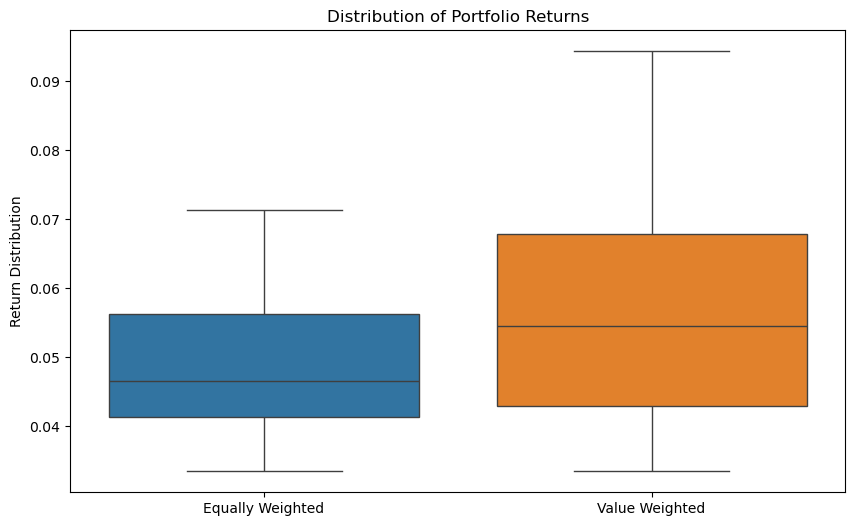

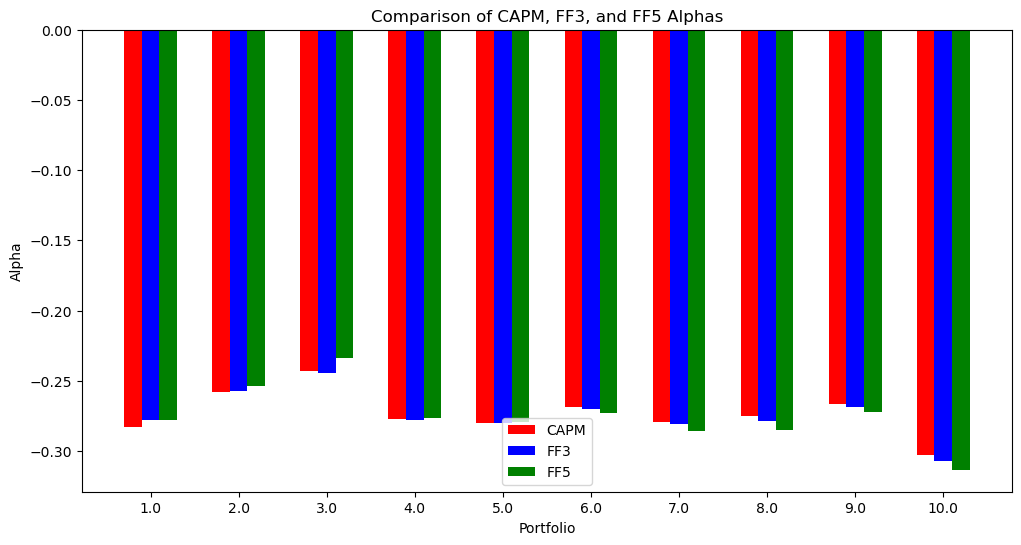

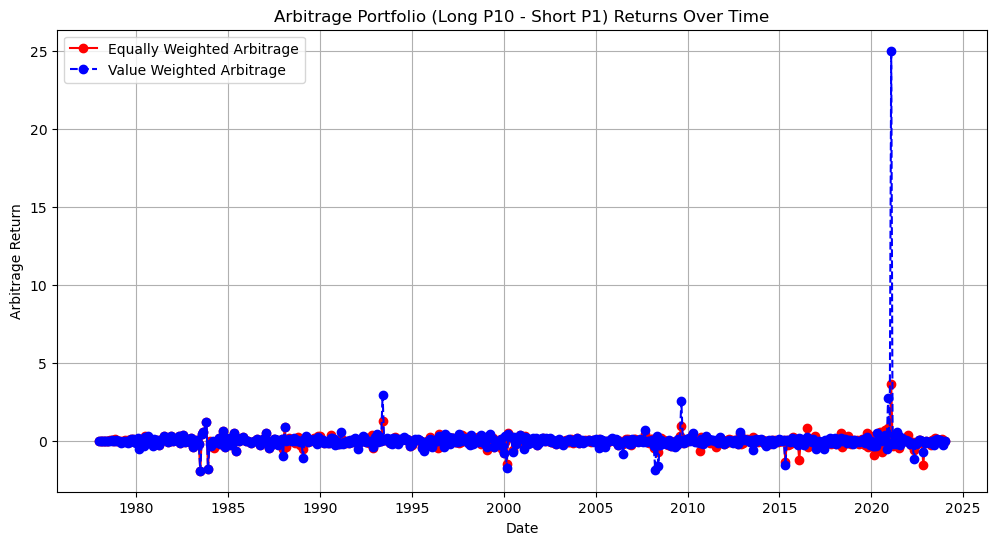

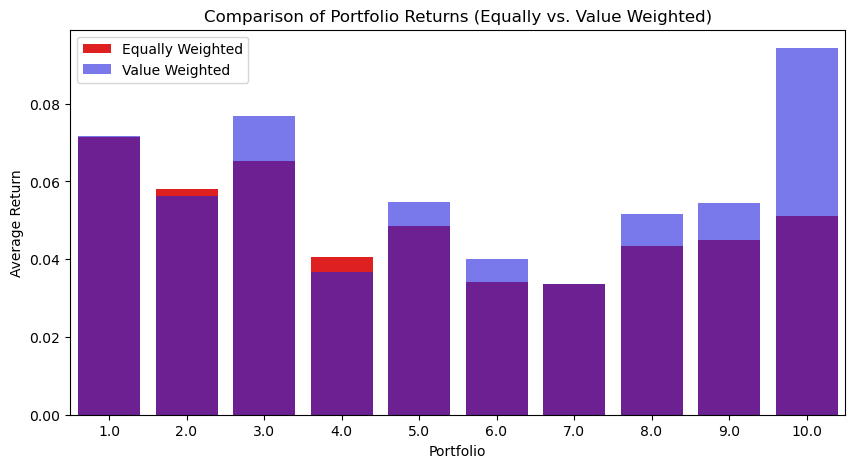

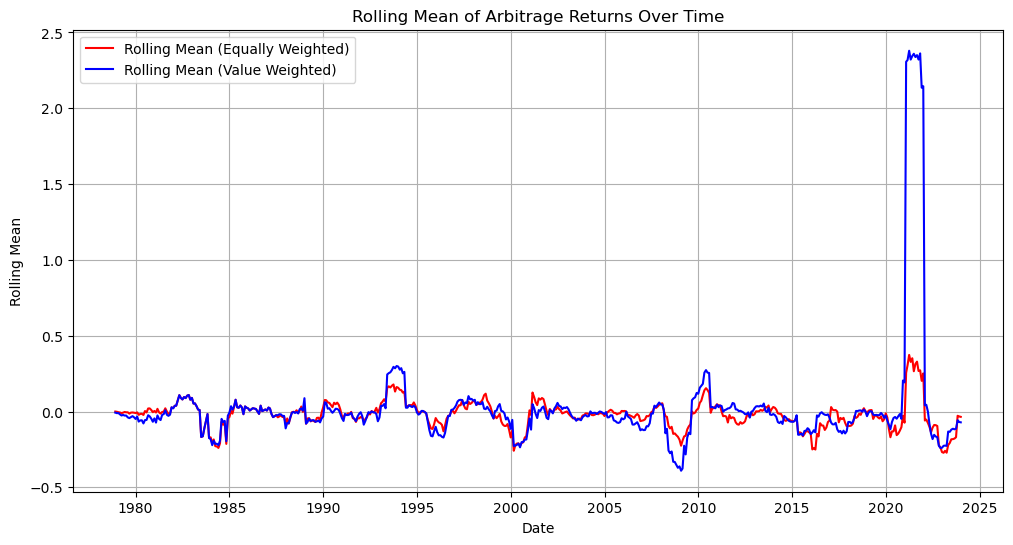

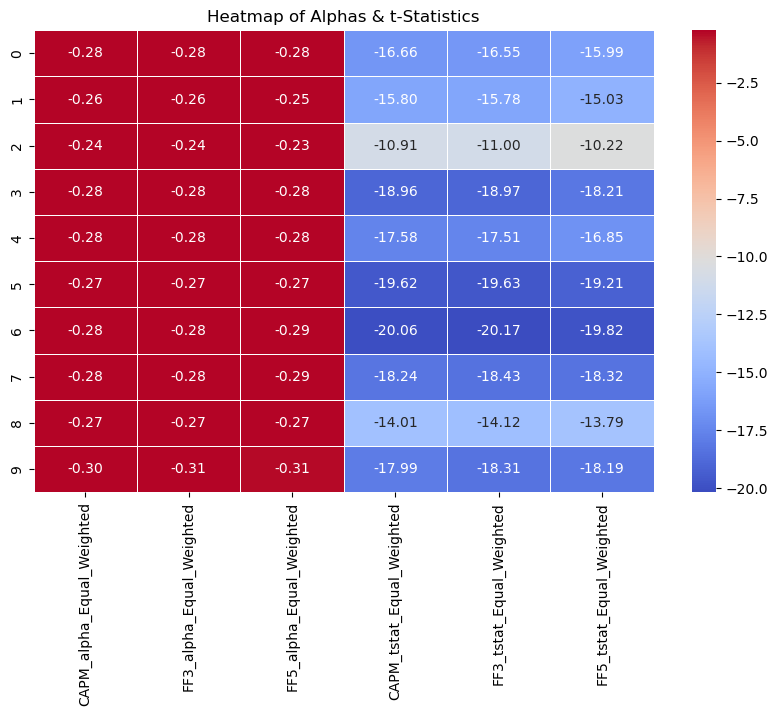

In [24]:
# ----------------------------
# Boxplot: Distribution of Portfolio Returns
# ----------------------------
plt.figure(figsize=(10,6))
sns.boxplot(data=portfolio_results[['Avg_Equal_Weighted_Return', 'Avg_Value_Weighted_Return']])
plt.xticks([0, 1], ['Equally Weighted', 'Value Weighted'])
plt.ylabel("Return Distribution")
plt.title("Distribution of Portfolio Returns")
plt.show()

# ----------------------------
# Bar Chart: Alphas from CAPM, FF3, FF5
# ----------------------------
fig, ax = plt.subplots(figsize=(12,6))
width = 0.2  # Width of bars

x = range(len(portfolio_results))  # X-axis positions
ax.bar([p - width for p in x], portfolio_results["CAPM_alpha_Equal_Weighted"], width=width, label="CAPM", color="red")
ax.bar(x, portfolio_results["FF3_alpha_Equal_Weighted"], width=width, label="FF3", color="blue")
ax.bar([p + width for p in x], portfolio_results["FF5_alpha_Equal_Weighted"], width=width, label="FF5", color="green")

ax.set_xticks(x)
ax.set_xticklabels(portfolio_results["Portfolio"])
ax.set_xlabel("Portfolio")
ax.set_ylabel("Alpha")
ax.set_title("Comparison of CAPM, FF3, and FF5 Alphas")
ax.legend()
plt.show()

# ----------------------------
# Arbitrage Portfolio Returns Over Time
# ----------------------------
plt.figure(figsize=(12,6))
plt.plot(arb_data["End_Date"], arb_data["Arbitrage_Equally_Weighted"], marker='o', linestyle='-', label="Equally Weighted Arbitrage", color='red')
plt.plot(arb_data["End_Date"], arb_data["Arbitrage_Value_Weighted"], marker='o', linestyle='--', label="Value Weighted Arbitrage", color='blue')
plt.xlabel("Date")
plt.ylabel("Arbitrage Return")
plt.title("Arbitrage Portfolio (Long P10 - Short P1) Returns Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Arbitrage Portfolio Returns Over Time - Charts

plt.figure(figsize=(10, 5))
sns.barplot(x="Portfolio", y="Avg_Equal_Weighted_Return", data=portfolio_results, color='red', label="Equally Weighted")
sns.barplot(x="Portfolio", y="Avg_Value_Weighted_Return", data=portfolio_results, color='blue', alpha=0.6, label="Value Weighted")
plt.xlabel("Portfolio")
plt.ylabel("Average Return")
plt.title("Comparison of Portfolio Returns (Equally vs. Value Weighted)")
plt.legend()
plt.show()

# ----------------------------
# Rolling Mean of Arbitrage Portfolio
# ----------------------------
rolling_window = 12  # 12-month rolling mean
arb_data["Rolling_Mean_Equally_Weighted"] = arb_data["Arbitrage_Equally_Weighted"].rolling(rolling_window).mean()
arb_data["Rolling_Mean_Value_Weighted"] = arb_data["Arbitrage_Value_Weighted"].rolling(rolling_window).mean()

plt.figure(figsize=(12,6))
plt.plot(arb_data["End_Date"], arb_data["Rolling_Mean_Equally_Weighted"], label="Rolling Mean (Equally Weighted)", color="red")
plt.plot(arb_data["End_Date"], arb_data["Rolling_Mean_Value_Weighted"], label="Rolling Mean (Value Weighted)", color="blue")
plt.xlabel("Date")
plt.ylabel("Rolling Mean")
plt.title("Rolling Mean of Arbitrage Returns Over Time")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------
# Heatmap of Alphas & t-Statistics
# ----------------------------
plt.figure(figsize=(10,6))
sns.heatmap(portfolio_results[["CAPM_alpha_Equal_Weighted", "FF3_alpha_Equal_Weighted", "FF5_alpha_Equal_Weighted",
                               "CAPM_tstat_Equal_Weighted", "FF3_tstat_Equal_Weighted", "FF5_tstat_Equal_Weighted"]],
            annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap of Alphas & t-Statistics")
plt.show()

In [25]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# -------------------------------
# Calcul des Ratios de Performance
# -------------------------------

def calculate_ratios(data_portfolio, market_excess_return, risk_free_rate):
    avg_return = data_portfolio.mean()
    std_return = data_portfolio.std()
    skewness = data_portfolio.skew()
    kurtosis = data_portfolio.kurtosis()
    drawdown = (data_portfolio / data_portfolio.cummax() - 1).min()
    calmar_ratio = avg_return / abs(drawdown) if drawdown != 0 else np.nan
    sortino_ratio = avg_return / data_portfolio[data_portfolio < 0].std() if data_portfolio[data_portfolio < 0].std() != 0 else np.nan
    var_95 = np.percentile(data_portfolio.dropna(), 5)
    
    # Treynor Ratio
    X = sm.add_constant(market_excess_return.values)
    y = (data_portfolio - risk_free_rate).values
    model = sm.OLS(y, X, missing='drop').fit()
    beta = model.params[1] if len(model.params) > 1 else np.nan
    treynor_ratio = avg_return / beta if beta != 0 else np.nan
    
    # Sharpe Ratio
    sharpe_ratio = (avg_return - risk_free_rate.mean()) / std_return if std_return != 0 else np.nan
    
    # Information Ratio
    tracking_error = (data_portfolio - market_excess_return).std()
    info_ratio = (avg_return - market_excess_return.mean()) / tracking_error if tracking_error != 0 else np.nan
    
    return [avg_return, std_return, skewness, kurtosis, calmar_ratio, sortino_ratio, var_95, treynor_ratio, sharpe_ratio, info_ratio]

# Stockage des résultats
performance_results = {}

for portfolio in sorted(portfolio_data['Portfolio'].unique()):
    data_portfolio = portfolio_data[portfolio_data['Portfolio'] == portfolio].copy()
    
    ratios_eq = calculate_ratios(data_portfolio['Equally_Weighted_Return'], data_portfolio['Mkt-RF'], data_portfolio['RF'])
    ratios_vw = calculate_ratios(data_portfolio['Value_Weighted_Return'], data_portfolio['Mkt-RF'], data_portfolio['RF'])
    
    performance_results[portfolio] = {
        "Metric": [
            "Average Return", "Standard Deviation", "Skewness", "Kurtosis",
            "Calmar Ratio", "Sortino Ratio", "VaR (95%)", "Treynor Ratio", "Sharpe Ratio", "Information Ratio"
        ],
        "Equally Weighted": [round(val, 4) if not np.isnan(val) else np.nan for val in ratios_eq],
        "Value Weighted": [round(val, 4) if not np.isnan(val) else np.nan for val in ratios_vw]
    }

# Affichage des résultats sous forme de blocs pour chaque portefeuille
for portfolio, metrics in performance_results.items():
    portfolio_df = pd.DataFrame(metrics)
    print(f"\nPerformance Metrics for Portfolio {portfolio}:")
    print(portfolio_df.to_string(index=False))



Performance Metrics for Portfolio 1:
            Metric  Equally Weighted  Value Weighted
    Average Return            0.0713          0.0717
Standard Deviation            0.2521          0.2724
          Skewness            4.9801          4.6567
          Kurtosis           42.6761         34.7542
      Calmar Ratio            0.0254          0.0000
     Sortino Ratio            0.8707          0.7943
         VaR (95%)           -0.1616         -0.1810
     Treynor Ratio            3.9629          3.9559
      Sharpe Ratio           -1.0739         -0.9926
 Information Ratio           -0.1375         -0.1375

Performance Metrics for Portfolio 2:
            Metric  Equally Weighted  Value Weighted
    Average Return            0.0581          0.0564
Standard Deviation            0.2163          0.2437
          Skewness            3.8682          5.2268
          Kurtosis           26.5478         46.0259
      Calmar Ratio            0.0212          0.0000
     Sortino Ratio     

In [26]:
# arbitrage ratios
arb_ratios_eq = calculate_ratios(arb_data['Arbitrage_Equally_Weighted'], arb_data['Mkt-RF'], arb_data['RF'])
arb_ratios_vw = calculate_ratios(arb_data['Arbitrage_Value_Weighted'], arb_data['Mkt-RF'], arb_data['RF'])

# we want to have a structured data frame 
metrics = [
    "Average Return", "Standard Deviation", "Skewness", "Kurtosis",
    "Calmar Ratio", "Sortino Ratio", "VaR (95%)", "Treynor Ratio", "Sharpe Ratio", "Information Ratio"
]

arb_performance_df = pd.DataFrame({
    "Metric": metrics,
    "Equally Weighted": [round(val, 4) for val in arb_ratios_eq],
    "Value Weighted": [round(val, 4) for val in arb_ratios_vw]
})

# table with the metrics for arbitrage portfolio
print("\nPerformance Metrics for Arbitrage Portfolio:\n")
print(arb_performance_df.to_string(index=False))



Performance Metrics for Arbitrage Portfolio:

            Metric  Equally Weighted  Value Weighted
    Average Return           -0.0203          0.0227
Standard Deviation            0.3209          1.1269
          Skewness            1.6851         20.0666
          Kurtosis           38.1313        445.4418
      Calmar Ratio           -0.0000          0.0000
     Sortino Ratio           -0.0780          0.0774
         VaR (95%)           -0.4232         -0.4160
     Treynor Ratio           -6.0284          5.4541
      Sharpe Ratio           -1.1293         -0.2835
 Information Ratio           -0.1555         -0.1423


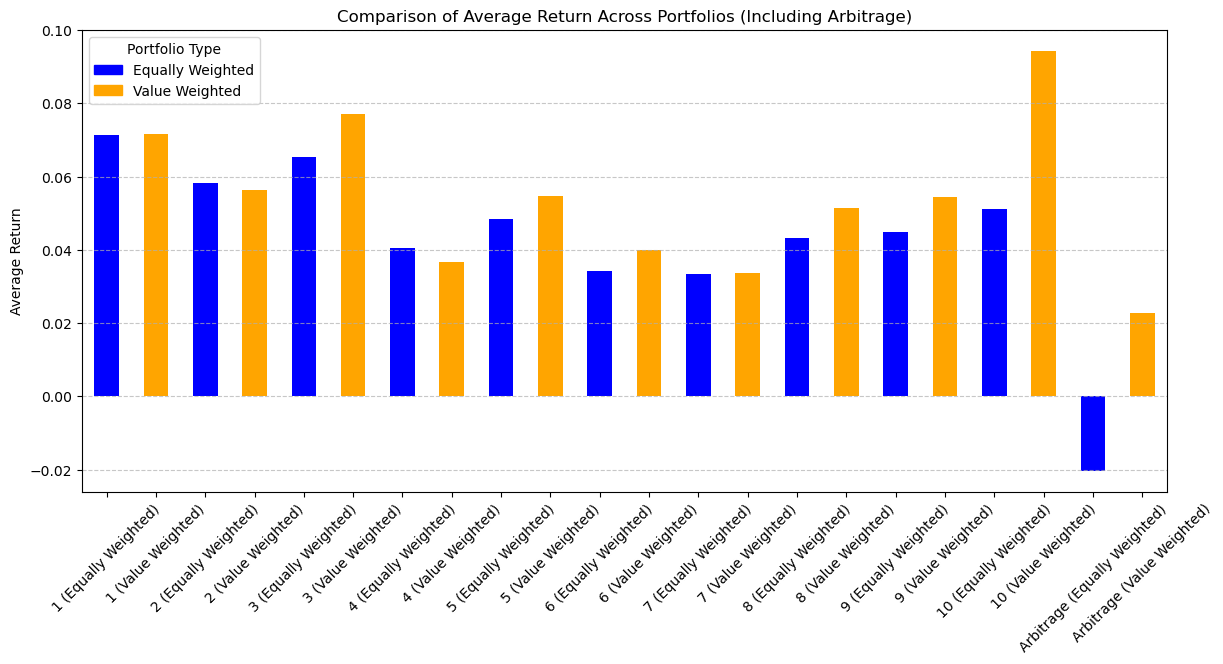

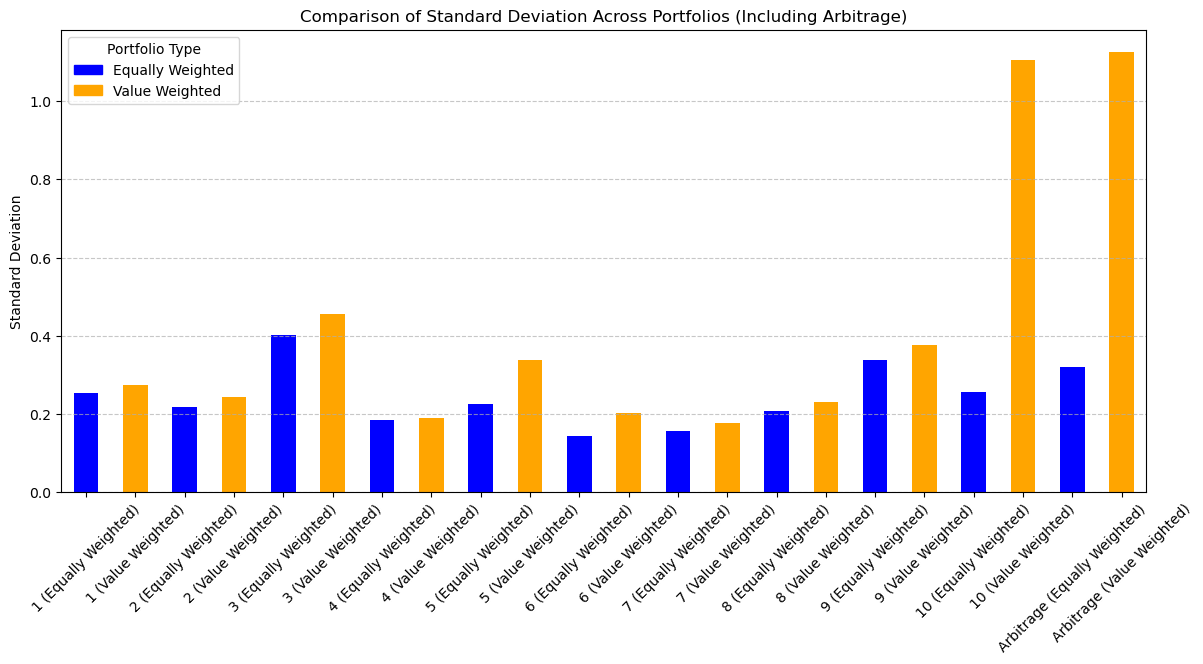

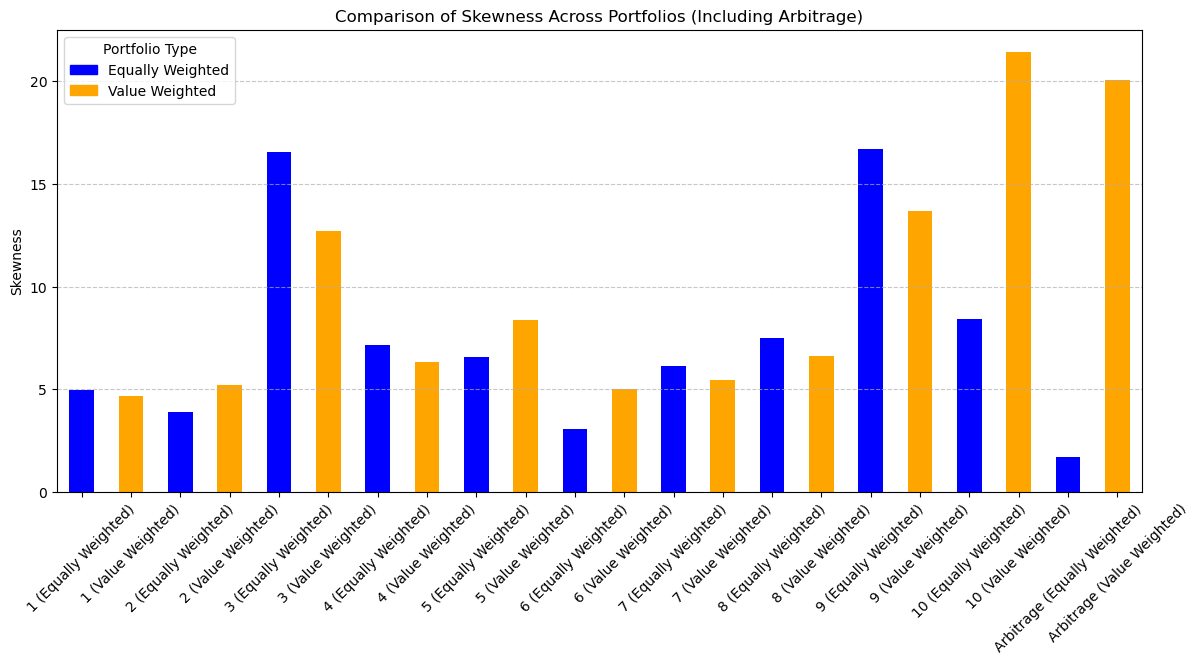

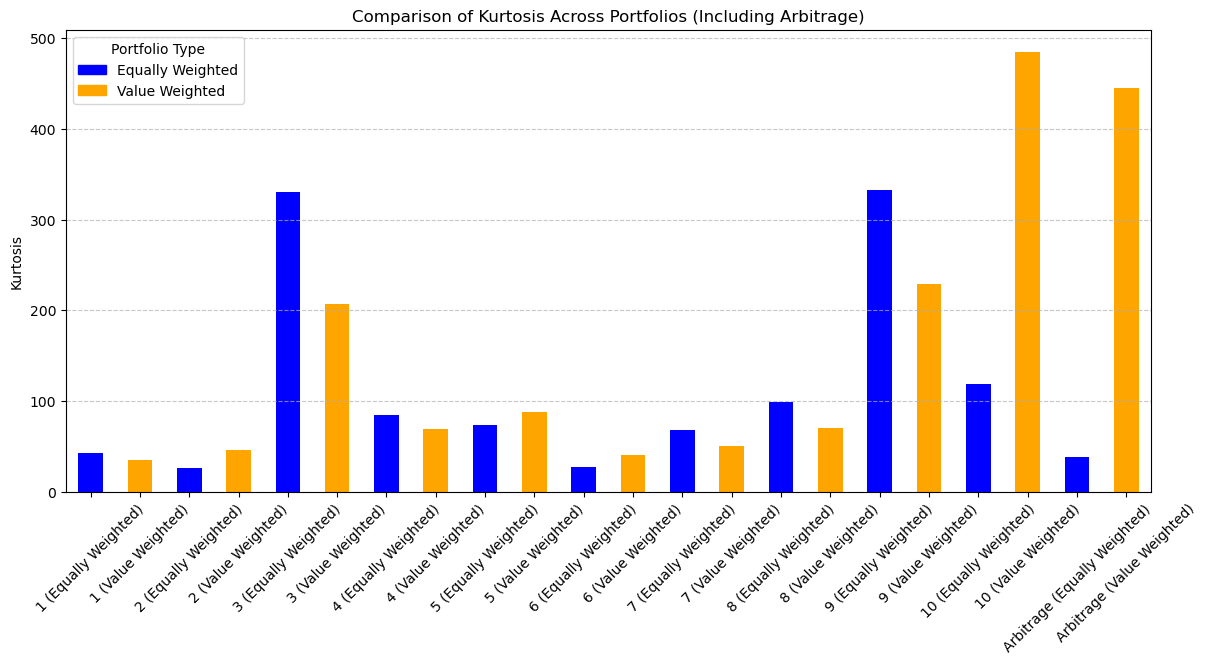

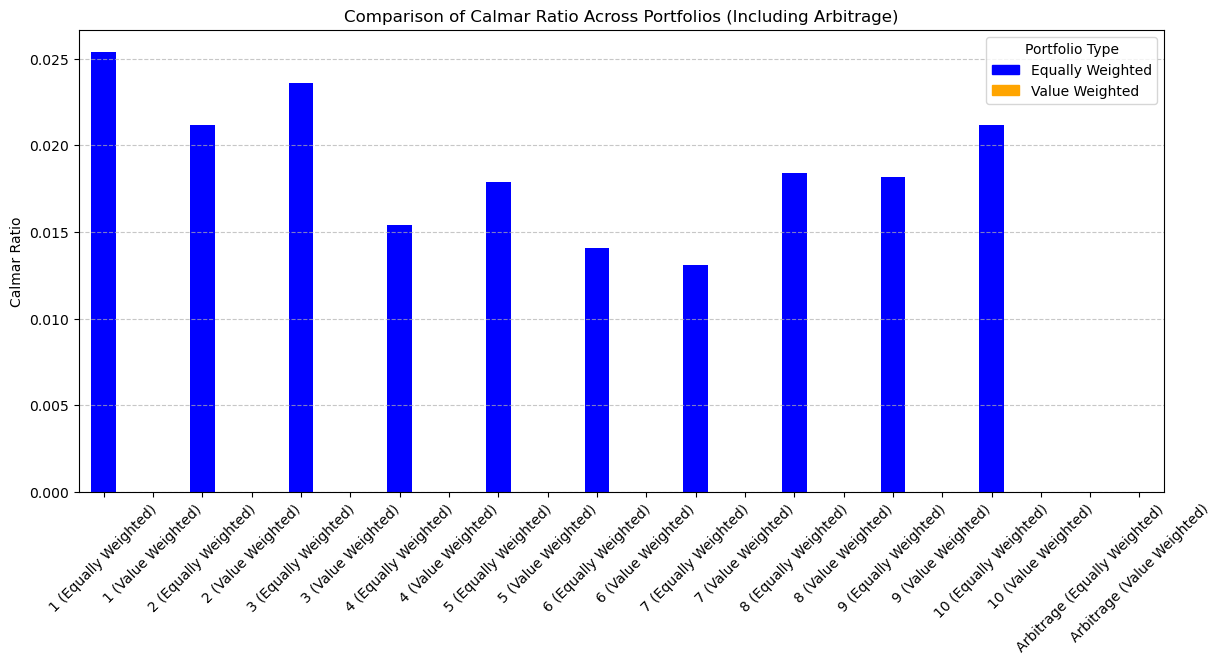

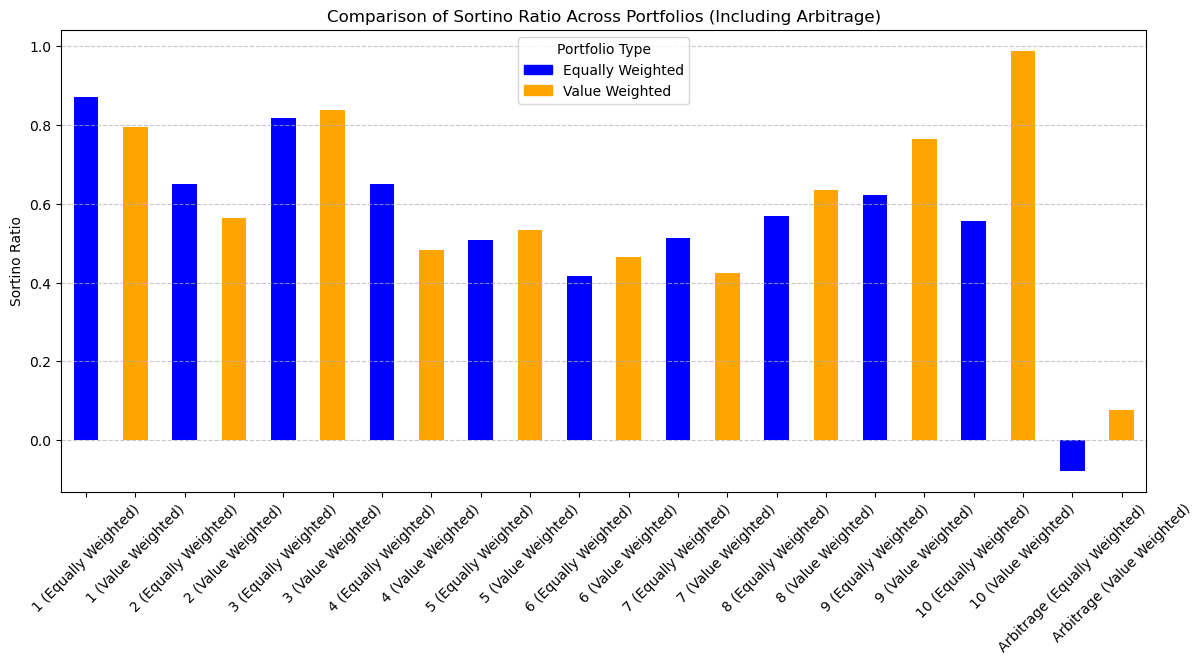

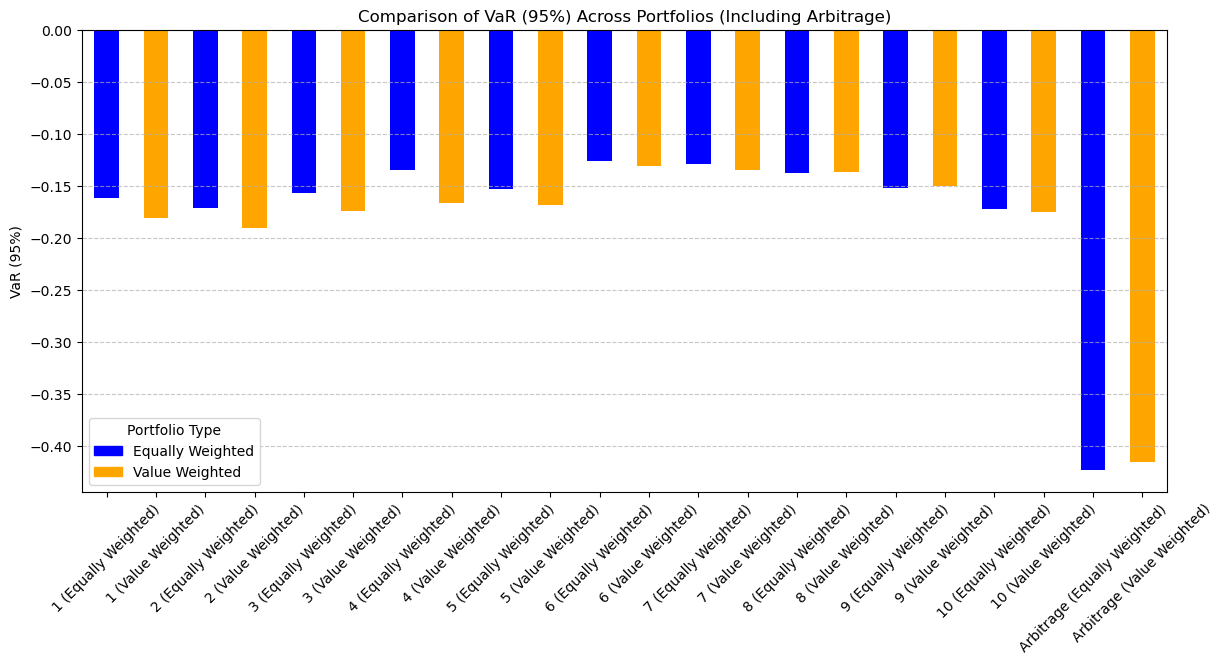

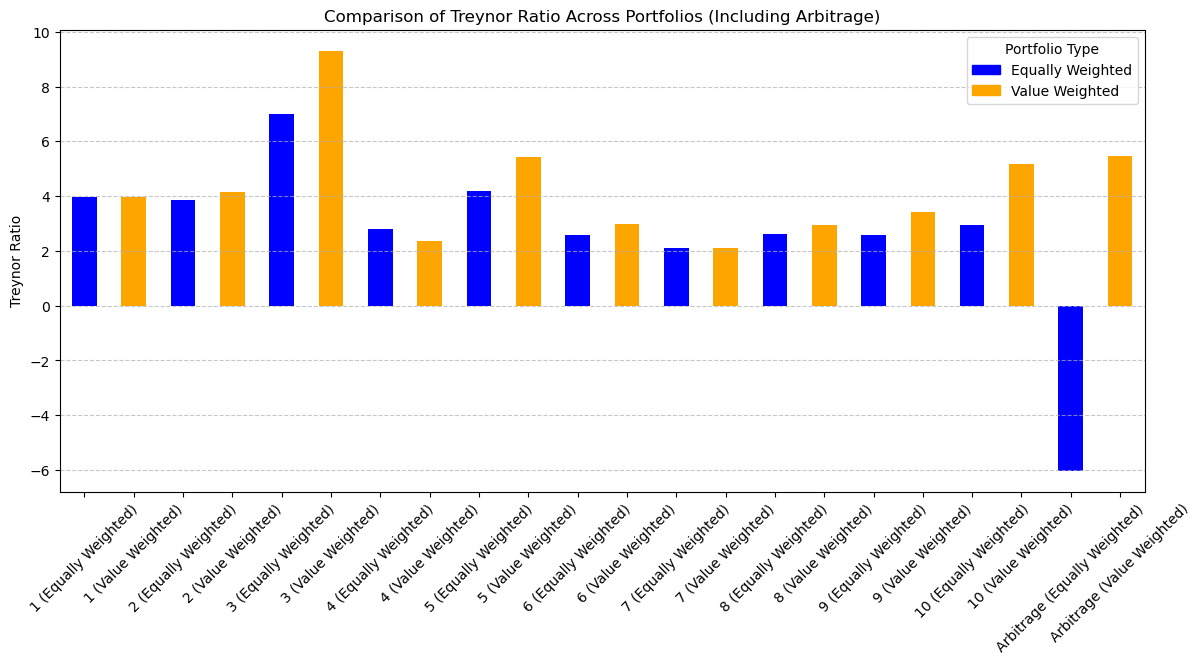

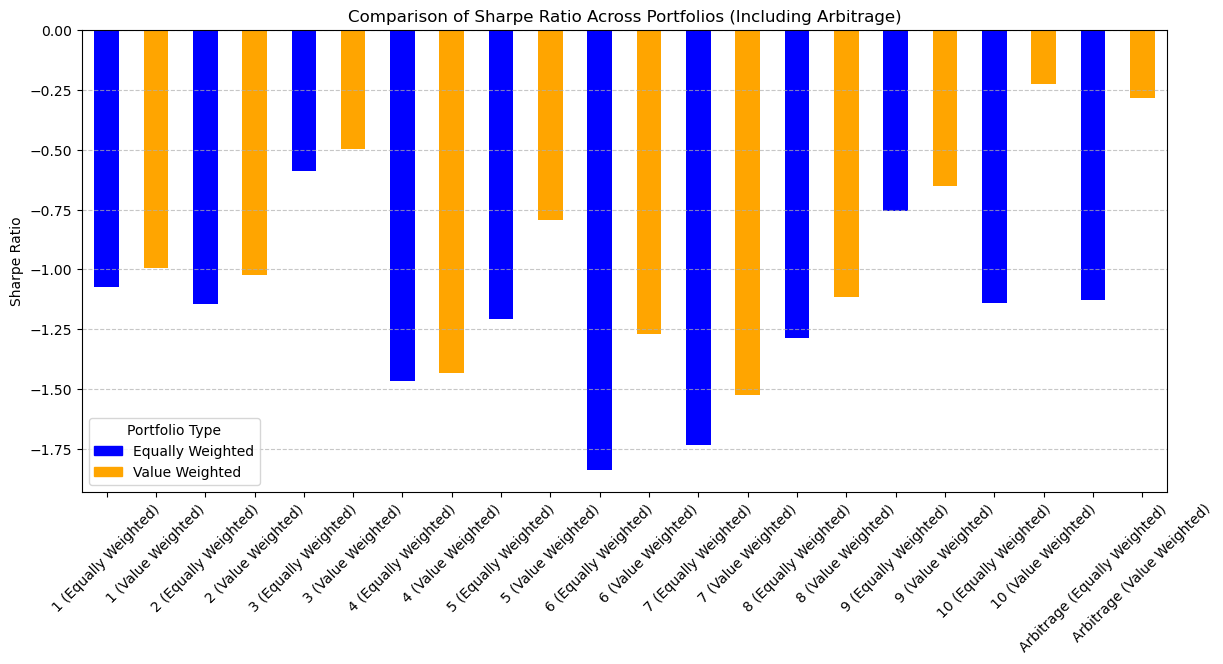

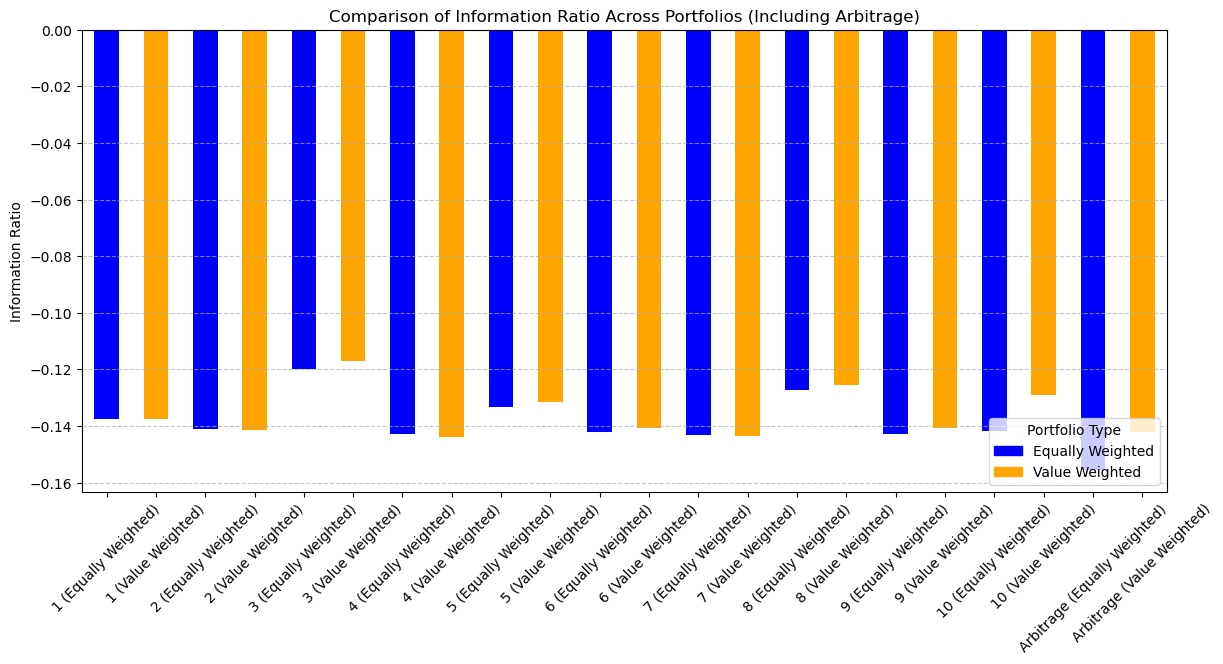

In [89]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Définition des couleurs pour chaque type de pondération
colors = {"Equally Weighted": "blue", "Value Weighted": "orange"}

# Affichage des graphiques comparatifs
for metric in metrics:
    plt.figure(figsize=(14, 6))

    # Générer les couleurs en fonction du type de pondération
    bar_colors = [colors["Equally Weighted"] if "Equally Weighted" in col else colors["Value Weighted"] for col in performance_table.columns]

    # Tracer le graphe avec les couleurs assignées
    performance_table.loc[metric].plot(kind='bar', color=bar_colors)

    plt.title(f"Comparison of {metric} Across Portfolios (Including Arbitrage)")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Création de la légende manuelle
    legend_patches = [
        mpatches.Patch(color="blue", label="Equally Weighted"),
        mpatches.Patch(color="orange", label="Value Weighted")
    ]
    plt.legend(handles=legend_patches, loc='best', title="Portfolio Type", frameon=True)

    plt.show()